# Matrix Factorization using sgd optimization 

In [16]:
import numpy as np
import pandas as pd

In [17]:
ratings = pd.read_csv('netflix_data.csv')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거

In [18]:
ratings

,user_id,movie_id,rating
0,2442,1,3
1,1719610,1,2
2,1011918,1,4
3,479924,1,5
4,2389367,1,1
...,...,...,...
507847,295393,4499,5
507848,305344,4499,1
507849,1627987,4499,1
507850,1988633,4499,4


In [19]:
# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings, random_state=1)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

## Algorithm

In [20]:
# New MF class for training & testing
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
##### >>>>> (2) user_id, item_id를 R의 index와 매핑하기 위한 dictionary 생성
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)        
        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)
#### <<<<< (2)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    # train set의 RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    # Ratings for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

##### >>>>> (3)
    # Test set을 선정
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):      # test 데이터에 있는 각 데이터에 대해서
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            z = ratings_test.iloc[i, 2]
            test_set.append([x, y, z])
            self.R[x, y] = 0                    # Setting test set ratings to 0
        self.test_set = test_set
        return test_set                         # Return test set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))

    # Training 하면서 test set의 정확도를 계산
    def test(self):
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 5 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

    # Full user-movie rating matrix
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)


### d=5, lambda = 0.02

In [21]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf5 = NEW_MF(R_temp, K=5, alpha=0.001, beta=0.02, iterations=50, verbose=True)
test_set = mf5.set_test(ratings_test)

import time
start = time.time()
result5 = mf5.test()
print(time.time()-start)

Iteration: 5 ; Train RMSE = 0.9725 ; Test RMSE = 0.9823
Iteration: 10 ; Train RMSE = 0.9486 ; Test RMSE = 0.9622
Iteration: 15 ; Train RMSE = 0.9365 ; Test RMSE = 0.9531
Iteration: 20 ; Train RMSE = 0.9289 ; Test RMSE = 0.9481
Iteration: 25 ; Train RMSE = 0.9234 ; Test RMSE = 0.9450
Iteration: 30 ; Train RMSE = 0.9192 ; Test RMSE = 0.9429
Iteration: 35 ; Train RMSE = 0.9157 ; Test RMSE = 0.9414
Iteration: 40 ; Train RMSE = 0.9126 ; Test RMSE = 0.9402
Iteration: 45 ; Train RMSE = 0.9096 ; Test RMSE = 0.9392
Iteration: 50 ; Train RMSE = 0.9066 ; Test RMSE = 0.9383
1667.2828891277313


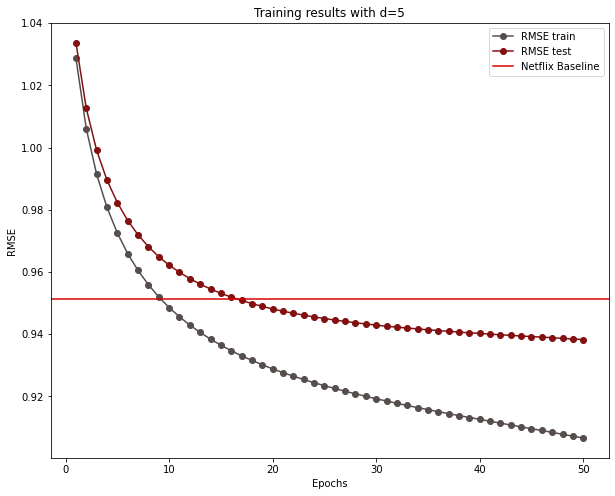

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result5)[:,0]
train_rmse_list = np.array(result5)[:,1]
test_rmse_list = np.array(result5)[:,2]

plt.title('Training results with d=5')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=10, lambda = 0.02

In [23]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf10 = NEW_MF(R_temp, K=10, alpha=0.001, beta=0.02, iterations=50, verbose=True)
test_set = mf10.set_test(ratings_test)

import time
start = time.time()
result10 = mf10.test()
print(time.time()-start)

Iteration: 5 ; Train RMSE = 0.9710 ; Test RMSE = 0.9800
Iteration: 10 ; Train RMSE = 0.9480 ; Test RMSE = 0.9604
Iteration: 15 ; Train RMSE = 0.9363 ; Test RMSE = 0.9516
Iteration: 20 ; Train RMSE = 0.9290 ; Test RMSE = 0.9467
Iteration: 25 ; Train RMSE = 0.9237 ; Test RMSE = 0.9436
Iteration: 30 ; Train RMSE = 0.9195 ; Test RMSE = 0.9415
Iteration: 35 ; Train RMSE = 0.9159 ; Test RMSE = 0.9400
Iteration: 40 ; Train RMSE = 0.9123 ; Test RMSE = 0.9385
Iteration: 45 ; Train RMSE = 0.9087 ; Test RMSE = 0.9371
Iteration: 50 ; Train RMSE = 0.9045 ; Test RMSE = 0.9356
1551.2333669662476


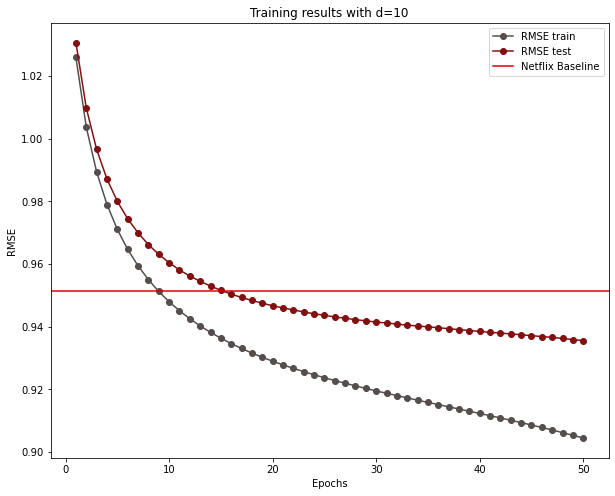

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result10)[:,0]
train_rmse_list = np.array(result10)[:,1]
test_rmse_list = np.array(result10)[:,2]

plt.title('Training results with d=10')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

In [63]:
pd.DataFrame(result10, columns = ['epoch','train','test']).to_csv("mf_b.csv", index=False)

### d=20, lambda = 0.02

In [25]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf20 = NEW_MF(R_temp, K=10, alpha=0.001, beta=0.02, iterations=50, verbose=True)
test_set = mf20.set_test(ratings_test)

import time
start = time.time()
result20 = mf20.test()
print(time.time()-start)

Iteration: 5 ; Train RMSE = 0.9712 ; Test RMSE = 0.9801
Iteration: 10 ; Train RMSE = 0.9481 ; Test RMSE = 0.9605
Iteration: 15 ; Train RMSE = 0.9365 ; Test RMSE = 0.9517
Iteration: 20 ; Train RMSE = 0.9292 ; Test RMSE = 0.9468
Iteration: 25 ; Train RMSE = 0.9240 ; Test RMSE = 0.9438
Iteration: 30 ; Train RMSE = 0.9199 ; Test RMSE = 0.9418
Iteration: 35 ; Train RMSE = 0.9163 ; Test RMSE = 0.9402
Iteration: 40 ; Train RMSE = 0.9131 ; Test RMSE = 0.9391
Iteration: 45 ; Train RMSE = 0.9098 ; Test RMSE = 0.9380
Iteration: 50 ; Train RMSE = 0.9062 ; Test RMSE = 0.9368
1534.759910106659


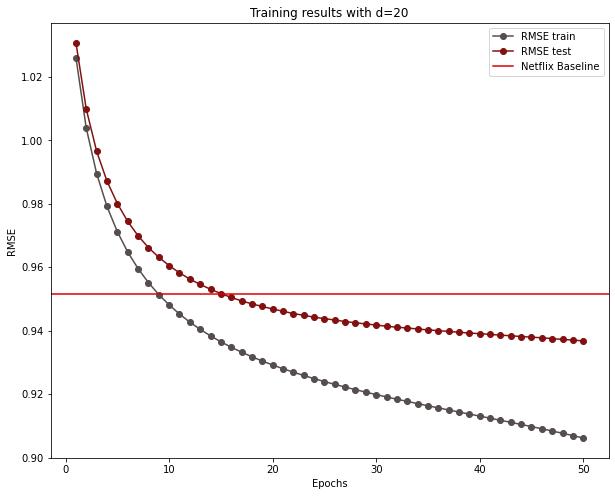

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result20)[:,0]
train_rmse_list = np.array(result20)[:,1]
test_rmse_list = np.array(result20)[:,2]

plt.title('Training results with d=20')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=30, lambda = 0.02

In [14]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf30 = NEW_MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=50, verbose=True)
test_set = mf30.set_test(ratings_test)

import time
start = time.time()
result30 = mf30.test()
print(time.time()-start)

Iteration: 5 ; Train RMSE = 0.9713 ; Test RMSE = 0.9796
Iteration: 10 ; Train RMSE = 0.9487 ; Test RMSE = 0.9601
Iteration: 15 ; Train RMSE = 0.9374 ; Test RMSE = 0.9513
Iteration: 20 ; Train RMSE = 0.9305 ; Test RMSE = 0.9464
Iteration: 25 ; Train RMSE = 0.9257 ; Test RMSE = 0.9433
Iteration: 30 ; Train RMSE = 0.9220 ; Test RMSE = 0.9412
Iteration: 35 ; Train RMSE = 0.9189 ; Test RMSE = 0.9397
Iteration: 40 ; Train RMSE = 0.9161 ; Test RMSE = 0.9385
Iteration: 45 ; Train RMSE = 0.9133 ; Test RMSE = 0.9373
Iteration: 50 ; Train RMSE = 0.9102 ; Test RMSE = 0.9360


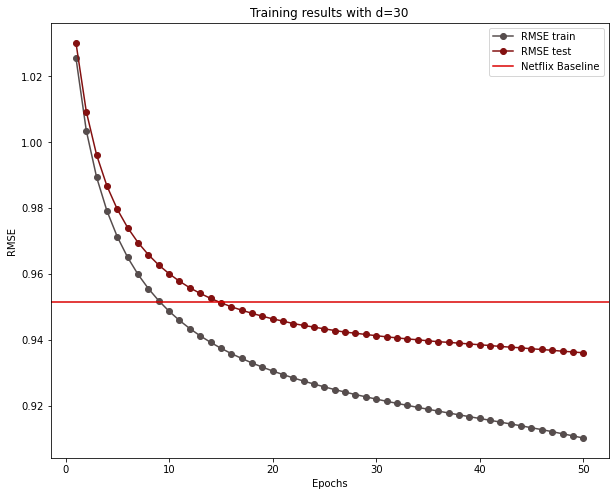

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result30)[:,0]
train_rmse_list = np.array(result30)[:,1]
test_rmse_list = np.array(result30)[:,2]

plt.title('Training results with d=30')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=10, lambda = 0.01

In [16]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=10, alpha=0.001, beta=0.01, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)
result01 = mf.test()

Iteration: 5 ; Train RMSE = 0.9709 ; Test RMSE = 0.9798
Iteration: 10 ; Train RMSE = 0.9477 ; Test RMSE = 0.9602
Iteration: 15 ; Train RMSE = 0.9360 ; Test RMSE = 0.9515
Iteration: 20 ; Train RMSE = 0.9285 ; Test RMSE = 0.9466
Iteration: 25 ; Train RMSE = 0.9230 ; Test RMSE = 0.9435
Iteration: 30 ; Train RMSE = 0.9185 ; Test RMSE = 0.9414
Iteration: 35 ; Train RMSE = 0.9143 ; Test RMSE = 0.9398
Iteration: 40 ; Train RMSE = 0.9100 ; Test RMSE = 0.9381
Iteration: 45 ; Train RMSE = 0.9051 ; Test RMSE = 0.9364
Iteration: 50 ; Train RMSE = 0.8994 ; Test RMSE = 0.9343


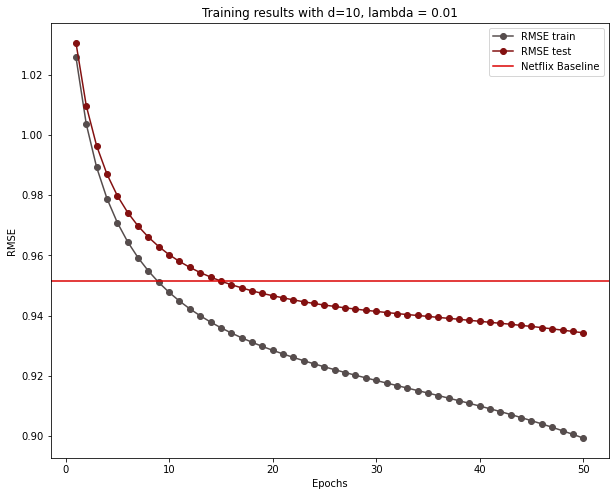

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result01)[:,0]
train_rmse_list = np.array(result01)[:,1]
test_rmse_list = np.array(result01)[:,2]

plt.title('Training results with d=10, lambda = 0.01')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=10, lambda = 0.05

In [20]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=10, alpha=0.001, beta=0.05, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)
result05 = mf.test()

Iteration: 5 ; Train RMSE = 0.9716 ; Test RMSE = 0.9804
Iteration: 10 ; Train RMSE = 0.9489 ; Test RMSE = 0.9610
Iteration: 15 ; Train RMSE = 0.9375 ; Test RMSE = 0.9521
Iteration: 20 ; Train RMSE = 0.9305 ; Test RMSE = 0.9471
Iteration: 25 ; Train RMSE = 0.9256 ; Test RMSE = 0.9441
Iteration: 30 ; Train RMSE = 0.9220 ; Test RMSE = 0.9420
Iteration: 35 ; Train RMSE = 0.9190 ; Test RMSE = 0.9404
Iteration: 40 ; Train RMSE = 0.9166 ; Test RMSE = 0.9393
Iteration: 45 ; Train RMSE = 0.9143 ; Test RMSE = 0.9383
Iteration: 50 ; Train RMSE = 0.9123 ; Test RMSE = 0.9375


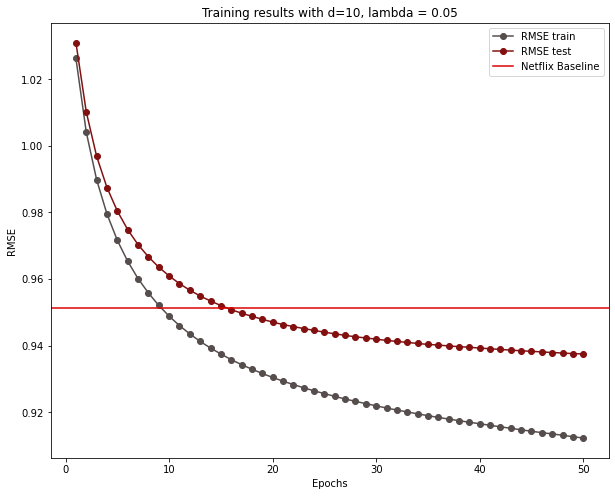

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result05)[:,0]
train_rmse_list = np.array(result05)[:,1]
test_rmse_list = np.array(result05)[:,2]

plt.title('Training results with d=10, lambda = 0.05')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=10, lambda = 0.1

In [22]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=10, alpha=0.001, beta=0.1, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)
result_1 = mf.test()

Iteration: 5 ; Train RMSE = 0.9727 ; Test RMSE = 0.9812
Iteration: 10 ; Train RMSE = 0.9504 ; Test RMSE = 0.9619
Iteration: 15 ; Train RMSE = 0.9392 ; Test RMSE = 0.9531
Iteration: 20 ; Train RMSE = 0.9325 ; Test RMSE = 0.9482
Iteration: 25 ; Train RMSE = 0.9279 ; Test RMSE = 0.9451
Iteration: 30 ; Train RMSE = 0.9245 ; Test RMSE = 0.9430
Iteration: 35 ; Train RMSE = 0.9218 ; Test RMSE = 0.9415
Iteration: 40 ; Train RMSE = 0.9198 ; Test RMSE = 0.9404
Iteration: 45 ; Train RMSE = 0.9180 ; Test RMSE = 0.9397
Iteration: 50 ; Train RMSE = 0.9165 ; Test RMSE = 0.9389


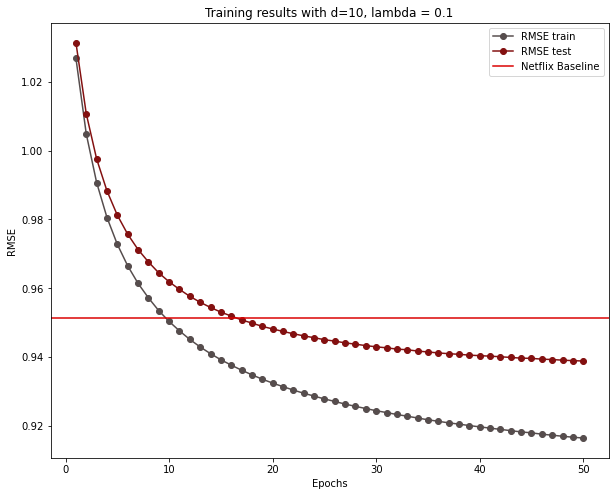

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result_1)[:,0]
train_rmse_list = np.array(result_1)[:,1]
test_rmse_list = np.array(result_1)[:,2]

plt.title('Training results with d=10, lambda = 0.1')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=20, lambda = 0.01

In [7]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=20, alpha=0.001, beta=0.01, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)

import time
start = time.time()
result20_01 = mf.test()
print(time.time()-start)

Iteration: 5 ; Train RMSE = 0.9710 ; Test RMSE = 0.9795
Iteration: 10 ; Train RMSE = 0.9482 ; Test RMSE = 0.9600
Iteration: 15 ; Train RMSE = 0.9368 ; Test RMSE = 0.9511
Iteration: 20 ; Train RMSE = 0.9296 ; Test RMSE = 0.9462
Iteration: 25 ; Train RMSE = 0.9245 ; Test RMSE = 0.9432
Iteration: 30 ; Train RMSE = 0.9203 ; Test RMSE = 0.9411
Iteration: 35 ; Train RMSE = 0.9166 ; Test RMSE = 0.9395
Iteration: 40 ; Train RMSE = 0.9128 ; Test RMSE = 0.9380
Iteration: 45 ; Train RMSE = 0.9085 ; Test RMSE = 0.9364
Iteration: 50 ; Train RMSE = 0.9032 ; Test RMSE = 0.9345
354.4637825489044


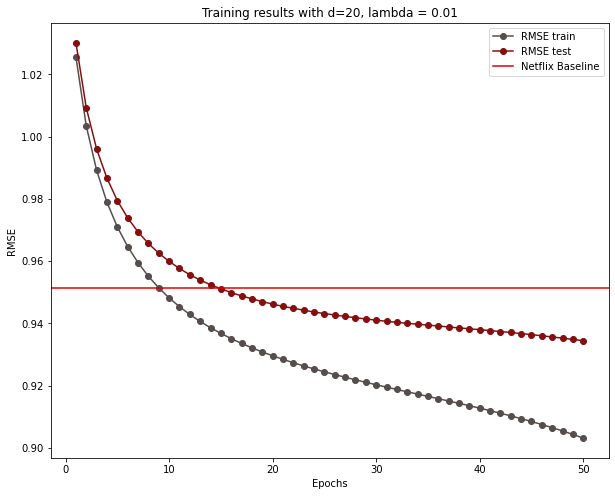

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result20_01)[:,0]
train_rmse_list = np.array(result20_01)[:,1]
test_rmse_list = np.array(result20_01)[:,2]

plt.title('Training results with d=20, lambda = 0.01')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

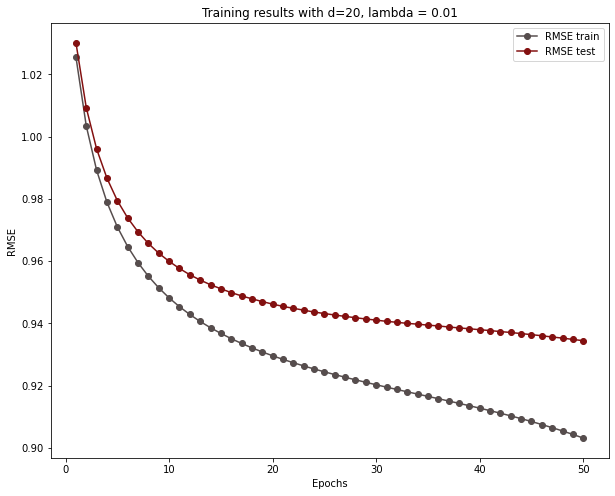

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result20_01)[:,0]
train_rmse_list = np.array(result20_01)[:,1]
test_rmse_list = np.array(result20_01)[:,2]

plt.title('Training results with d=20, lambda = 0.01')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
#plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=20, lambda = 0.05

In [10]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=20, alpha=0.001, beta=0.05, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)

import time
start = time.time()
result20_05 = mf.test()
print(time.time()-start)

Iteration: 5 ; Train RMSE = 0.9717 ; Test RMSE = 0.9802
Iteration: 10 ; Train RMSE = 0.9492 ; Test RMSE = 0.9607
Iteration: 15 ; Train RMSE = 0.9381 ; Test RMSE = 0.9518
Iteration: 20 ; Train RMSE = 0.9312 ; Test RMSE = 0.9469
Iteration: 25 ; Train RMSE = 0.9265 ; Test RMSE = 0.9439
Iteration: 30 ; Train RMSE = 0.9230 ; Test RMSE = 0.9418
Iteration: 35 ; Train RMSE = 0.9202 ; Test RMSE = 0.9403
Iteration: 40 ; Train RMSE = 0.9179 ; Test RMSE = 0.9392
Iteration: 45 ; Train RMSE = 0.9159 ; Test RMSE = 0.9383
Iteration: 50 ; Train RMSE = 0.9140 ; Test RMSE = 0.9375
353.8110542297363


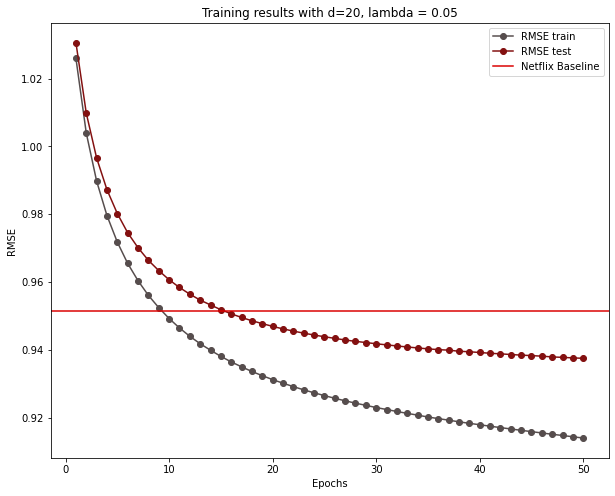

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result20_05)[:,0]
train_rmse_list = np.array(result20_05)[:,1]
test_rmse_list = np.array(result20_05)[:,2]

plt.title('Training results with d=20, lambda = 0.05')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=20, lambda = 0.1

In [13]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=20, alpha=0.001, beta=0.1, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)

import time
start = time.time()
result20_1 = mf.test()
print(time.time()-start)

Iteration: 5 ; Train RMSE = 0.9729 ; Test RMSE = 0.9811
Iteration: 10 ; Train RMSE = 0.9507 ; Test RMSE = 0.9618
Iteration: 15 ; Train RMSE = 0.9398 ; Test RMSE = 0.9531
Iteration: 20 ; Train RMSE = 0.9331 ; Test RMSE = 0.9482
Iteration: 25 ; Train RMSE = 0.9285 ; Test RMSE = 0.9450
Iteration: 30 ; Train RMSE = 0.9252 ; Test RMSE = 0.9430
Iteration: 35 ; Train RMSE = 0.9226 ; Test RMSE = 0.9415
Iteration: 40 ; Train RMSE = 0.9206 ; Test RMSE = 0.9405
Iteration: 45 ; Train RMSE = 0.9189 ; Test RMSE = 0.9396
Iteration: 50 ; Train RMSE = 0.9175 ; Test RMSE = 0.9390
358.29302644729614


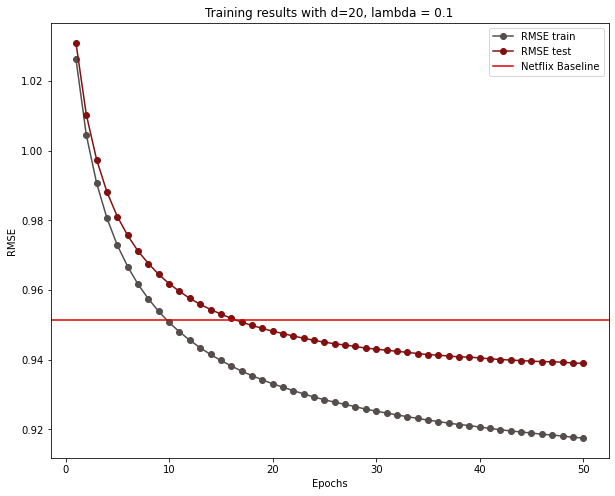

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result20_1)[:,0]
train_rmse_list = np.array(result20_1)[:,1]
test_rmse_list = np.array(result20_1)[:,2]

plt.title('Training results with d=20, lambda = 0.1')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

## 최종 모델 결과 확인

In [35]:
user_id = 2442
R_2442 = []
for i in mf10.item_id_index.keys():
    R_2442.append(mf10.get_one_prediction(2442, i))

In [38]:
df_movies = pd.read_csv('netflix_data/movie_titles.csv', encoding = "ISO-8859-1", 
                        header = None, names = ['movie_id', 'year', 'title'])

In [40]:
R_2442 = pd.DataFrame(R_2442).reset_index()
R_2442.columns = ['movie_id','rating_pred']

In [44]:
R_result = pd.merge(pd.merge(df_movies, R_2442, how='inner', on='movie_id'), 
                    ratings[ratings['user_id']==user_id].drop('user_id',axis=1), how='left', on='movie_id')

In [45]:
R_fitted = R_result[R_result['rating'].isna()==False]
R_fitted = R_fitted[['movie_id','title','rating','rating_pred']].reset_index(drop=True)

In [46]:
R_fitted.head(10)

,movie_id,title,rating,rating_pred
0,1,Dinosaur Planet,3.0,3.307235
1,30,Something's Gotta Give,3.0,3.589936
2,188,Dead Birds,3.0,3.304152
3,191,X2: X-Men United,4.0,3.462255
4,283,If These Walls Could Talk,4.0,3.451830
5,457,Kill Bill: Vol. 2,3.0,3.664112
6,486,Journey to the Center of the Earth,4.0,3.288731
7,514,Santana: Supernatural Live,3.0,3.405161
8,528,The Hitchhiker's Guide to the Galaxy,4.0,3.445424
9,594,By Hook or By Crook,2.0,3.819438


In [47]:
# 원래 취향
R_fitted.sort_values(by=['rating'], ascending=False).head(10)

,movie_id,title,rating,rating_pred
18,1084,Walking with Prehistoric Beasts,5.0,3.661165
73,2862,The Silence of the Lambs,5.0,3.529433
23,1391,Yanni: Live at the Acropolis,5.0,3.434659
78,3113,Dante's Peak,5.0,3.478117
79,3184,Desert Hearts,5.0,3.413284
26,1470,Bend It Like Beckham,5.0,3.458431
27,1482,Beyond Borders,5.0,3.457147
92,3671,Laughing Matters,5.0,3.394318
57,2452,Lord of the Rings: The Fellowship of the Ring,5.0,3.936750
31,1709,Clash of the Titans,5.0,3.393939


In [48]:
R_pred = R_result[R_result['rating'].isna()==True]
R_pred = R_pred[['movie_id','title','rating','rating_pred']].reset_index(drop=True)

In [49]:
# 추천
R_pred.sort_values(by=['rating_pred'], ascending=False).head(10)

,movie_id,title,rating,rating_pred
3363,3453,The Man Who Knew Too Much,NaN,4.620457
4307,4424,Elton John: Live in Barcelona,NaN,4.511962
1906,1945,From Hell: Bonus Material,NaN,4.477076
2055,2100,Bliss,NaN,4.474524
2484,2546,The Second Coming,NaN,4.423051
1446,1474,Classic Country Comedy,NaN,4.414985
4236,4350,The Best of the New Scooby-Doo Movies,NaN,4.394918
2965,3044,The Inheritance,NaN,4.360222
2392,2450,Inserts,NaN,4.359082
3351,3441,Kicking & Screaming,NaN,4.353238
